In [380]:
# Import the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
import seaborn as sns
from IPython.display import Image
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, roc_auc_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler


In [381]:
#Functions
def slice_by_country(country_names, country_column_name, data_frame):
    sliced_df = data_frame[data_frame[country_column_name].isin(country_names)]
    return sliced_df
def map_countries_to_numeric(countries_mapping,country_column_name,numeric_column_name,df):
    numeric_mapping_vals = []
    # loop through the rows using iterrows()
    for index, row in df.iterrows():
        if row[country_column_name] in countries_mapping:
            numeric_mapping_vals += [countries_mapping[row[country_column_name]]]
            print(numeric_mapping_vals)
    df[numeric_column_name] = numeric_mapping_vals
    return df

In [392]:
population_df = pd.read_csv("https://ourworldindata.org/grapher/population.csv?country=USA~BRA~AUS~ESP~ZWE~MDV~JPN&v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
meat_df = pd.read_csv("Consumption of meat per capita.csv")

In [393]:
def filter_countries_by_names(data_frame, countries_list, country_column_name):
    filtered_df = data_frame[data_frame[country_column_name].isin(countries_list)]
    return filtered_df
countries_to_pull = ['United States', 'Brazil', 'Australia', 'Spain', 'Zimbabwe', 'Maldives', 'Japan']
filtered_population_df = filter_countries_by_names(population_df, countries_to_pull, 'Entity')
filtered_population_df = filtered_population_df.drop(columns=['Code'])
print(filtered_population_df)

          Entity   Year  population_historical
3316   Australia -10000                 314500
3317   Australia  -9000                 314500
3318   Australia  -8000                 314501
3319   Australia  -7000                 314501
3320   Australia  -6000                 314501
...          ...    ...                    ...
59172   Zimbabwe   2019               15271377
59173   Zimbabwe   2020               15526888
59174   Zimbabwe   2021               15797220
59175   Zimbabwe   2022               16069061
59176   Zimbabwe   2023               16340829

[1790 rows x 3 columns]


In [394]:
years_to_include = list(range(1961, 2022))
filtered_population_df_years = filtered_population_df[filtered_population_df['Year'].isin(years_to_include)]
filtered_population_df_years

,Entity,Year,population_historical
3514,Australia,1961,10500443
3515,Australia,1962,10707235
3516,Australia,1963,10913271
3517,Australia,1964,11128257
3518,Australia,1965,11357478
...,...,...,...
59170,Zimbabwe,2017,14812484
59171,Zimbabwe,2018,15034457
59172,Zimbabwe,2019,15271377
59173,Zimbabwe,2020,15526888


In [395]:
meat_df = filter_countries_by_names(meat_df, countries_to_pull, 'Entity')
meat_df = meat_df.drop(columns= ['Beef', 'Sheep and goat', 'Pork', 'Other meats'])
meat_df.head()

,Entity,Year,Poultry,Fish and seafood
396,Australia,1961,4.795002,12.806650
397,Australia,1962,4.650889,11.677125
398,Australia,1963,4.659573,8.820262
399,Australia,1964,5.302078,12.631126
400,Australia,1965,6.314754,12.789628


In [ ]:
filtered_population_df_years["Year"] = pd.to_numeric(filtered_population_df_years["Year"], errors='coerce')
meat_df["Year"] = pd.to_numeric(meat_df["Year"], errors='coerce')
combined_df = pd.merge(filtered_population_df_years, meat_df, on=["Entity", "Year"], how="inner")
combined_df.head()

C:\Users\Bryan\AppData\Local\Temp\ipykernel_33752\2317070001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_population_df_years["Year"] = pd.to_numeric(filtered_population_df_years["Year"], errors='coerce')


,Entity,Year,population_historical,Poultry,Fish and seafood
0,Australia,1961,10500443,4.795002,12.806650
1,Australia,1962,10707235,4.650889,11.677125
2,Australia,1963,10913271,4.659573,8.820262
3,Australia,1964,11128257,5.302078,12.631126
4,Australia,1965,11357478,6.314754,12.789628
5,Australia,1966,11592486,5.942793,14.288848
6,Australia,1967,11810519,7.464011,13.467672
7,Australia,1968,12030011,8.471889,13.209189
8,Australia,1969,12272387,8.806054,13.394256
9,Australia,1970,12599414,9.703055,13.104760


In [397]:
combined_df = slice_by_country(['United States', 'Brazil', 'Austrailia', 'Spain', 'Zimbabwe', 'Maldives', 'Japan'],'Entity',combined_df)
combined_df = map_countries_to_numeric({'United States':1, 'Brazil':2, 'Austrailia':3, 'Spain':4, 'Zimbabwe':5, 'Maldives':6, 'Japan':7},'Entity','country_index',combined_df)


[2]
[2, 2]
[2, 2, 2]
[2, 2, 2, 2]
[2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [430]:
features = ['Year','country_index', 'Poultry', 'Fish and seafood']
target = 'population_historical'

# Remove rows with missing values
df_clean = combined_df.dropna(subset=features + [target])
X = df_clean[features]
y = df_clean[target]
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [431]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Initialize and train Gradient Boosting model
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
# Train model
gb_model.fit(X_train_scaled, y_train)
# Make predictions
y_pred = gb_model.predict(X_test_scaled)



In [448]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Model Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

Model Performance Metrics:
MSE: 4460617381850.2021
RMSE: 2112017.3725
MAE: 1201616.8522
R2 Score: 0.9994


In [433]:
# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [434]:
# Print best parameters and score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Score:", np.sqrt(-grid_search.best_score_))


Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 2334258.422338381


In [435]:
# Train final model with best parameters
best_gb = grid_search.best_estimator_
best_pred = best_gb.predict(X_test_scaled)

In [436]:
# Calculate final metrics
final_mse = mean_squared_error(y_test, best_pred)
final_r2 = r2_score(y_test, best_pred)
print("\nFinal Model Performance:")
print(f"MSE: {final_mse:.4f}")
print(f"R2 Score: {final_r2:.4f}")


Final Model Performance:
MSE: 2618538942733.1230
R2 Score: 0.9997


In [437]:
# Feature importance plot
plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({
    'feature': features,
    'importance': best_gb.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=True)
importance_df

,feature,importance
0,Year,0.022732
2,Poultry,0.034600
3,Fish and seafood,0.122793
1,country_index,0.819876


<Figure size 1000x600 with 0 Axes>

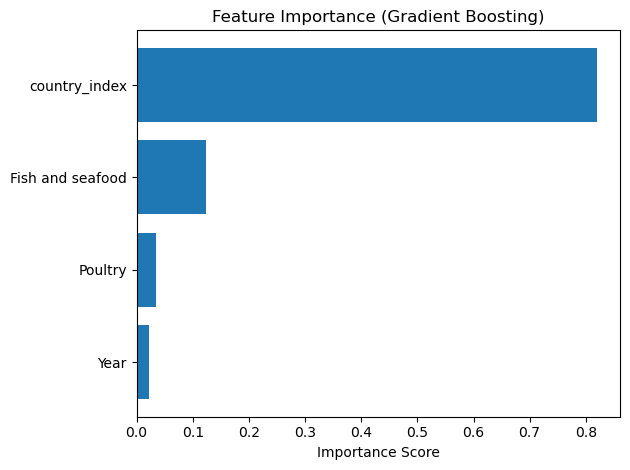

In [438]:
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance (Gradient Boosting)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

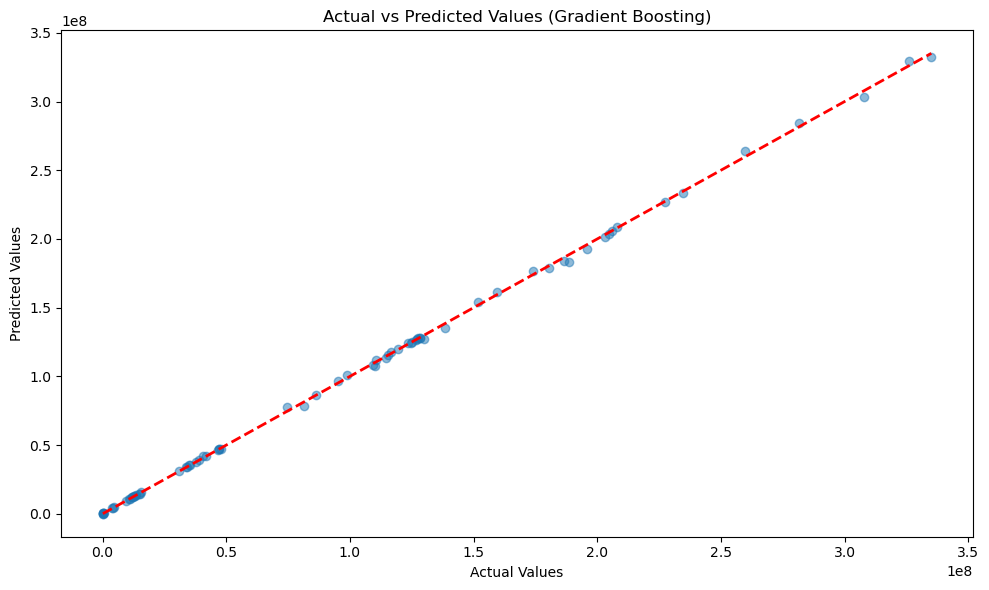

In [439]:
# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Gradient Boosting)')
plt.tight_layout()
plt.show()

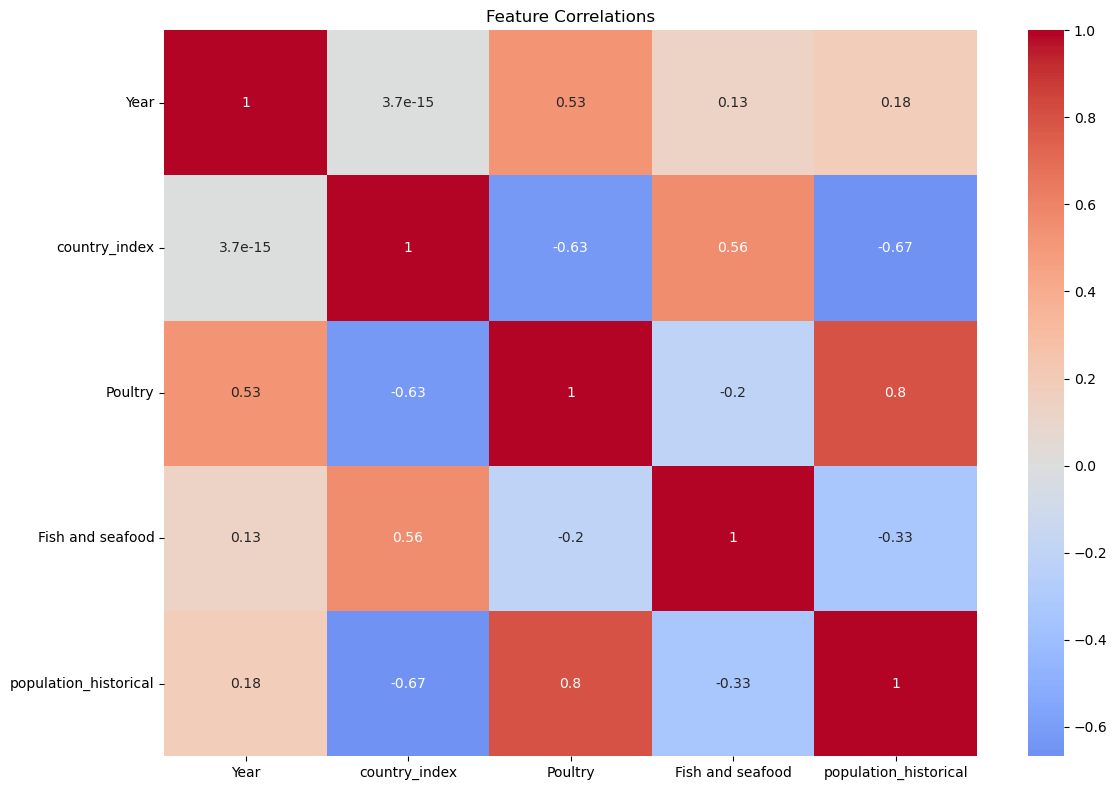

In [440]:
# Additional analysis: Feature correlations
plt.figure(figsize=(12, 8))
correlation_matrix = df_clean[features + [target]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

In [444]:
# Future Predicition
future_years = np.arange(2021, 2032)
countries = df_clean['country_index'].unique()
future_data = pd.DataFrame([(year, country) for year in future_years for country in countries], columns=['Year', 'country_index'])
latest_poultry = df_clean.groupby('country_index')['Poultry'].last()
latest_fish_and_seafood = df_clean.groupby('country_index')['Fish and seafood'].last()
future_data['Poultry'] = future_data['country_index'].map(latest_poultry)
future_data['Fish and seafood'] = future_data['country_index'].map(latest_fish_and_seafood)
latest_population = df_clean.groupby('country_index')['population_historical'].last()
future_data['population_historical'] = future_data['country_index'].map(latest_population)
future_data_scaled = scaler.transform(future_data[features])
future_predictions = gb_model.predict(future_data_scaled)
future_data['Predicted_Poultry_Consumption'] = future_predictions
print(future_data[['Year', 'country_index', 'Predicted_Poultry_Consumption']])

    Year  country_index  Predicted_Poultry_Consumption
0   2021              2                   2.095148e+08
1   2021              7                   1.256991e+08
2   2021              6                   5.319711e+05
3   2021              4                   4.772533e+07
4   2021              1                   3.401136e+08
..   ...            ...                            ...
61  2031              7                   1.256991e+08
62  2031              6                   5.319711e+05
63  2031              4                   4.772533e+07
64  2031              1                   3.401136e+08
65  2031              5                   1.572116e+07

[66 rows x 3 columns]


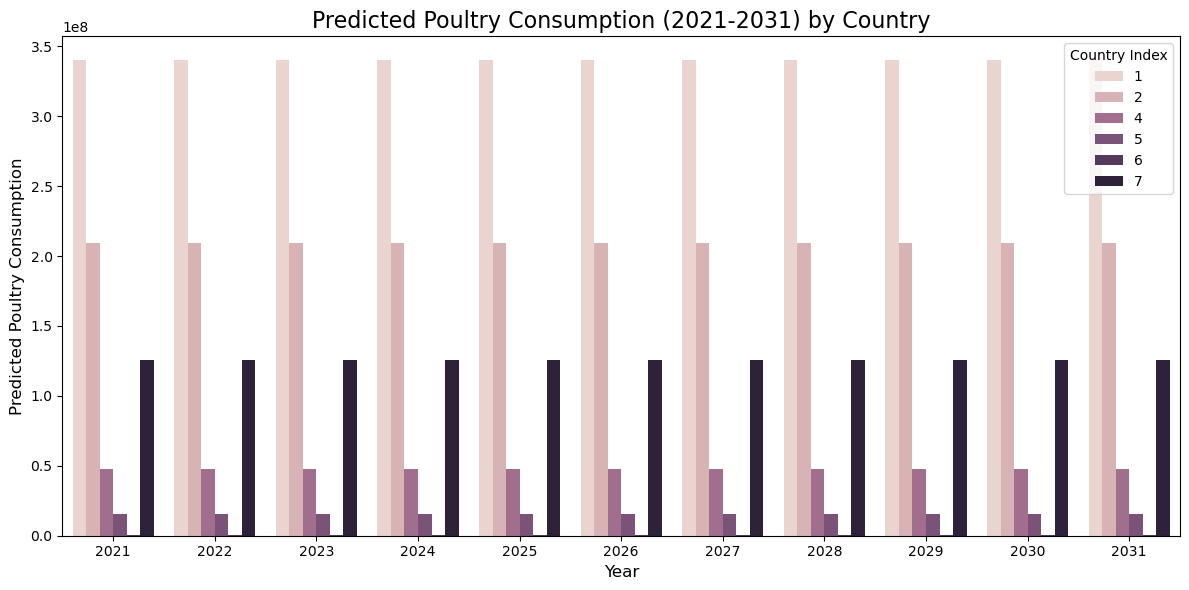

In [446]:
#Graph Code:
plt.figure(figsize=(12, 6))
sns.barplot(data=future_data, x='Year', y='Predicted_Poultry_Consumption', hue='country_index', errorbar=None)
plt.title('Predicted Poultry Consumption (2021-2031) by Country', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Predicted Poultry Consumption', fontsize=12)
plt.legend(title='Country Index', loc='upper right')
plt.tight_layout()
plt.show()

In [447]:
future_data.to_csv('future_poultry_consumption_predictions.csv', index=False)
print("CSV file 'future_poultry_consumption_predictions.csv' has been saved.")

CSV file 'future_poultry_consumption_predictions.csv' has been saved.
